In [ ]:
#==========================================
#=====LSTM Regression for Time-Series =====
#==========================================

In [ ]:
# Import libraries
import pandas as pd   #handle data tables easily
import numpy as np    #fast math calculations
import time           #measure training time
#create simple visual plots
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn → main ML library used for preprocessing, training & evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential   #Used to build a linear stack of layers
from tensorflow.keras.layers import LSTM, Dense, Dropout  #LSTM: Long Short-Term Memory layer, specialized for time-series/sequential data. | Dense: outputs the final prediction. |Dropout: Randomly drops a fraction of neurons during training to prevent overfitting.
from tensorflow.keras.callbacks import EarlyStopping   # Monitors a chosen metric and stops training early
from tensorflow.keras.optimizers import Adam #Optimization algorithm that updates weights efficiently using adaptive learning rates.

In [ ]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Progress Review 2 & 3_Pgno68/processed_final_scaled.csv',
                 parse_dates=['datetime'], index_col='datetime').sort_index()

#Define features (X) and target (y)
target_col = 'Global_active_power_log'
feature_cols = [
    'Global_reactive_power_log', 'Voltage_log', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'lag_1', 'lag_60', 'lag_1440', 'roll_mean_60', 'roll_std_60',
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5'
]
X = df[feature_cols]
y = df[target_col]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Train-Test Split (80% train, 20% test)
split_index = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Take a small sample for faster training (1–2% of data)
sample_frac_train = 0.005  # 0.5% ~ 10k rows
sample_frac_test  = 0.005  # 0.5% ~ 10k rows

X_train_sample = X_train.sample(frac=sample_frac_train, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

X_test_sample = X_test.sample(frac=sample_frac_test, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

In [ ]:
#scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.transform(X_test_sample)

In [ ]:
#Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [ ]:
# Metrics function
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))
    return rmse, mae, r2, rae

results = []

#EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
#==============================================
# VARIATION 1: Simple LSTM
#==============================================
model1 = Sequential([
    LSTM(16, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model1.compile(optimizer='adam', loss='mse')

start = time.time()
history1 = model1.fit(
    X_train_lstm, y_train_sample,
    epochs=10, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
end = time.time()

# Flatten predictions
y_pred_train1 = model1.predict(X_train_lstm).flatten()
y_pred_test1  = model1.predict(X_test_lstm).flatten()

# compute metrics
rmse_train1, mae_train1, r2_train1, rae_train1 = compute_metrics(y_train_sample, y_pred_train1)
rmse_test1, mae_test1, r2_test1, rae_test1 = compute_metrics(y_test_sample, y_pred_test1)


results.append([
    'Variation 1 - Simple LSTM', rmse_train1, mae_train1, r2_train1, rae_train1,
    rmse_test1, mae_test1, r2_test1, rae_test1, end-start
])


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1489 - val_loss: 0.0112
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 8.7442e-04
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1361e-04 - val_loss: 7.0060e-04
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7597e-04 - val_loss: 6.1617e-04
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6864e-04 - val_loss: 4.8896e-04
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


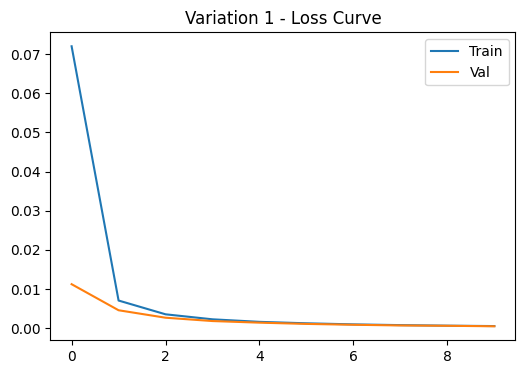

In [ ]:
# Loss Plot
plt.figure(figsize=(6,4))
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Val')
plt.legend(); plt.title('Variation 1 - Loss Curve'); plt.show()

In [ ]:
#==========================================================
# VARIATION 2: Tuned LSTM (Dropout + More Units)
#==========================================================
model2 = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

start = time.time()
history2 = model2.fit(
    X_train_lstm, y_train_sample,
    epochs=15, batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
end = time.time()

# Flatten predictions
y_pred_train2 = model2.predict(X_train_lstm).flatten()
y_pred_test2  = model2.predict(X_test_lstm).flatten()

# Compute metrics
rmse_train2, mae_train2, r2_train2, rae_train2 = compute_metrics(y_train_sample, y_pred_train2)
rmse_test2, mae_test2, r2_test2, rae_test2 = compute_metrics(y_test_sample, y_pred_test2)

results.append([
    'Variation 2 - Tuned LSTM', rmse_train2, mae_train2, r2_train2, rae_train2,
    rmse_test2, mae_test2, r2_test2, rae_test2, end-start
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1096 - val_loss: 0.0062
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 7.7790e-04
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 5.4917e-04
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 4.3187e-04
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5899e-04 - val_loss: 3.8780e-04
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0750e-04 - val_loss: 3.5689e-04
Epoch 9/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9045e-04 - val_loss: 3.0457e-04
Epoch 10/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5621e-04 - val_loss: 2.8289e-04
Epoch 11/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5787e-04 - val_loss: 2.5840e-0

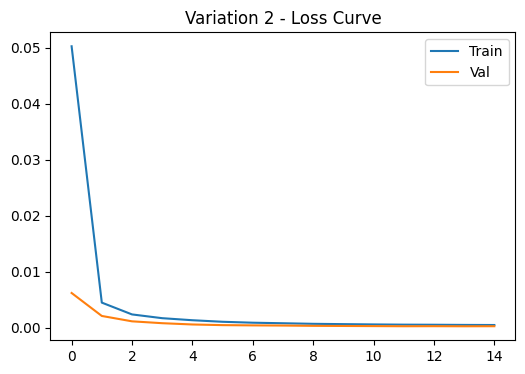

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Val')
plt.legend(); plt.title('Variation 2 - Loss Curve'); plt.show()

In [ ]:
#==========================================================
# VARIATION 3: Stacked LSTM (Deeper Network)
#==========================================================

model3 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

start = time.time()
history3 = model3.fit(
    X_train_lstm, y_train_sample,
    epochs=15, batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
end = time.time()

# Flatten predictions
y_pred_train3 = model3.predict(X_train_lstm).flatten()
y_pred_test3  = model3.predict(X_test_lstm).flatten()

# Compute metrics
rmse_train3, mae_train3, r2_train3, rae_train3 = compute_metrics(y_train_sample, y_pred_train3)
rmse_test3, mae_test3, r2_test3, rae_test3 = compute_metrics(y_test_sample, y_pred_test3)

# Store results
results.append([
    'Variation 3 - Stacked LSTM', rmse_train3, mae_train3, r2_train3, rae_train3,
    rmse_test3, mae_test3, r2_test3, rae_test3, end-start
])


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1252 - val_loss: 0.0043
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 8.6073e-04
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 6.3438e-04
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014 - val_loss: 5.1277e-04
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012 - val_loss: 4.0467e-04
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010 - val_loss: 3.2571e-04
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.9323e-04 - val_loss: 2.9888e-04
Epoch 9/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7528e-04 - val_loss: 2.8204e-04
Epoch 10/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7154e-04 - val_loss: 2.5288e-04
Epoch 11/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3656e-04 - val_loss: 2.2446e-04


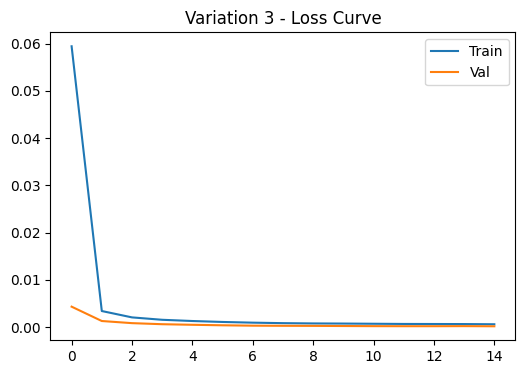

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Val')
plt.legend(); plt.title('Variation 3 - Loss Curve'); plt.show()


=== LSTM Variations: Train/Test Metrics ===


,Variation,RMSE_train,MAE_train,R2_train,RAE_train,RMSE_test,MAE_test,R2_test,RAE_test,Time_sec
0,Variation 1 - Simple LSTM,0.021918,0.015745,0.994584,0.058905,0.021946,0.016037,0.993310,0.067351,13.284057
1,Variation 2 - Tuned LSTM,0.014810,0.010856,0.997527,0.040615,0.016085,0.011311,0.996406,0.047502,20.738380
2,Variation 3 - Stacked LSTM,0.013826,0.010092,0.997845,0.037758,0.014818,0.010035,0.996950,0.042144,27.206859


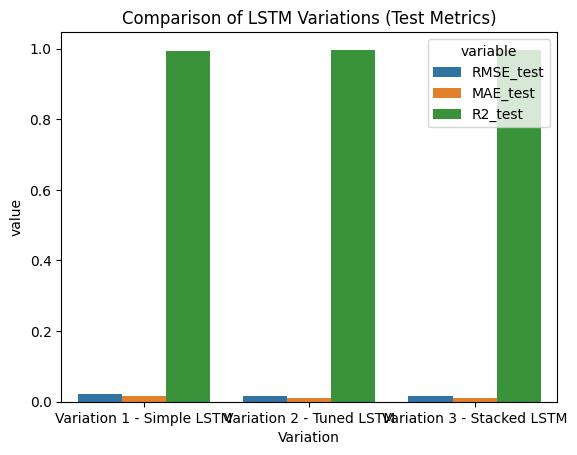

In [ ]:
#==========================================================
# EVALUATION & COMPARISON
#==========================================================
res_df_final = pd.DataFrame(results, columns=[
    'Variation', 'RMSE_train', 'MAE_train', 'R2_train', 'RAE_train',
    'RMSE_test', 'MAE_test', 'R2_test', 'RAE_test', 'Time_sec'
])

print("\n=== LSTM Variations: Train/Test Metrics ===")
display(res_df_final)

# Comparison Plot
res_df_melt = res_df_final.melt(id_vars='Variation',
                                value_vars=['RMSE_test', 'MAE_test', 'R2_test'])
sns.barplot(data=res_df_melt, x='Variation', y='value', hue='variable')
plt.title('Comparison of LSTM Variations (Test Metrics)')
plt.show()

In [ ]:
#==========================================================
# CONCLUSION
#==========================================================
best_model = res_df_final.sort_values(['R2_test', 'RMSE_test'], ascending=[False, True]).iloc[0]
print("\n=== Best Performing Variation ===")
print(f"Variation: {best_model['Variation']}")
print(f"Test RMSE: {best_model['RMSE_test']:.4f}")
print(f"Test R2: {best_model['R2_test']:.4f}")

print("\nObservations:")
print("- LSTM captures temporal dependencies better than KNN or SVR.")
print("- Tuned and stacked LSTM performed better with dropout regularization.")
print("- Early stopping prevented overfitting and reduced training time.")
print("- Best model achieved highest R² and lowest RMSE (Variation 3).")


=== Best Performing Variation ===
Variation: Variation 3 - Stacked LSTM
Test RMSE: 0.0148
Test R2: 0.9970

Observations:
- LSTM captures temporal dependencies better than KNN or SVR.
- Tuned and stacked LSTM performed better with dropout regularization.
- Early stopping prevented overfitting and reduced training time.
- Best model achieved highest R² and lowest RMSE (Variation 3).
